In [1]:
import pandas as pd
import numpy as np
import random
import time
import re

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from nltk import ngrams

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

: 

# 1. Анализ и предварительная обработка данных

Датасет **Sentiment Analysis for Mental Health** взят с KAGGLE.
Ссылка на датасет: https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health

Он содержит в себе 53043 строк с сообщениями/высказываниями, помеченными одним из 7 состояний психических расстройств:
- Normal (нормальное состояние)
- Depression (депрессивное состояние)
- Suicidal (суицидальное)
- Anxiety (тревожное состояние)
- Stress (стрессовое состояние)
- Bi-Polar (биполярное расстройство)
- Personality Disorder (расстройство личности)

In [2]:
df = pd.read_csv('Combined Data.csv')
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


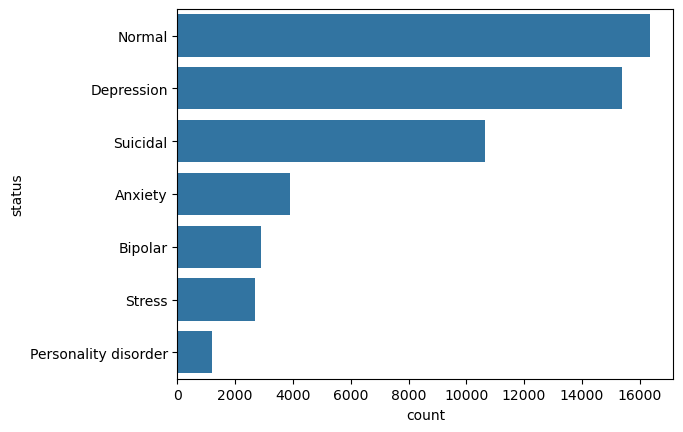

In [4]:
sns.countplot(df['status'], order=df['status'].value_counts().index)
plt.show()

Предварительная обработка данных включает в себя:

1. Удаление пустых значений
2. Приведение текста к нижнему регистру и удаление лишних символов
3. Удаление стоп-слов, стемминг и токенизация
4. Удаление выбросов
5. Преобразование категориальных данных в числа

**1. Удаление пустых значений**

In [5]:
df = df.drop('Unnamed: 0', axis=1)
df = df.dropna().reset_index(drop=True)

**2. Приведение текста к нижнему регистру, удаление лищних символов**

Датасет содержит достаточно много сокращений, например, "i can't" вместо "i cannot". Так как датасет в последующем планируется очистить от слов, состоящих и одного символа, и всех небуквенных символов, то "i can't" превратится в "can", и смысл такого предложения теряется (то есть "I can't live" после обработки превратится в "can live"). Чтобы этого избежать, подобные совращения будут заменены на свои полные версии.

Кроме того, будут удалены ссылки, цифры, лишние пробелы и прочие символы.

In [6]:
def text_сleaner(df, field_name, new_field_name):
    df[new_field_name] = df[field_name].str.lower()
    df[new_field_name] = df[new_field_name].str.replace(r'[’‘`]', '\'', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'i[\'|’]m\b', 'i am', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'\'ve\b', ' have', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'\'d\b', ' would', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'\'ll\b', ' will', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'\'re\b', ' are', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'\'s\b', ' ', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'n t\b', 'n\'t', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'can\'t\b', 'cannot', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'won\'t\b', 'will not', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'n\'t\b', ' not', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'http\S+', ' ', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'&', ' and ', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'[^a-z]', ' ', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'(.)\1{2,}', r'\1', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'\s+', ' ', regex=True)

    return df

In [7]:
df = text_сleaner(df, 'statement', 'cleared_statement')
df.head()

,statement,status,cleared_statement
0,oh my gosh,Anxiety,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,i have shifted my focus to something else but ...
4,"I'm restless and restless, it's been a month n...",Anxiety,i am restless and restless it been a month now...


**3. Удаление стоп-слов, стемминг и токенизация**

Текст будут токенизирован по пробелам и приведен к начальной форме с помощью стемминга. Затем из него будет удалены стоп-слова и слова, состоящие менее чем из 2 символов.
В случае удаления стоп-слов еще стоит поэкспериментировать. Так как список стоп-слов может содержать важные для контекста слова.

In [ ]:
def text_stemmer(text):
    # stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    clean_text = []
    for word in text.split(' '):
        norm_word = stemmer.stem(word)
        # if norm_word not in stop_words and len(norm_word) > 1:
        if len(norm_word) > 1:
            clean_text.append(norm_word.strip())

    return clean_text

In [9]:
df['stemmed_tokens'] = df['cleared_statement'].apply(text_stemmer)
df['cleared_statement'] = df['stemmed_tokens'].apply(lambda x: ' '.join(x))
df.head()

,statement,status,cleared_statement,stemmed_tokens
0,oh my gosh,Anxiety,oh my gosh,"[oh, my, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,troubl sleep confus mind restless heart all ou...,"[troubl, sleep, confus, mind, restless, heart,..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ..."
3,I've shifted my focus to something else but I'...,Anxiety,have shift my focu to someth els but am still ...,"[have, shift, my, focu, to, someth, els, but, ..."
4,"I'm restless and restless, it's been a month n...",Anxiety,am restless and restless it been month now boy...,"[am, restless, and, restless, it, been, month,..."


**4. Удаление выбросов**

Для анализа выбросов необходимо вычислить длину предложений и содержащееся в них количество слов. По этим значениям в последующем будет происходить фильтрация данных.

In [10]:
df['len_statement'] = df['cleared_statement'].apply(lambda x: len(x))
df['words_count'] = df['stemmed_tokens'].apply(lambda x: len(x))
df.sort_values('words_count')

,statement,status,cleared_statement,stemmed_tokens,len_statement,words_count
6700,'«ð š «ð ©ð ²ð «..â £ ® © ®ð ¡ð ð ²ð «ð ..ðŸ' ...,Normal,,[],0,0
10332,9111 10335,Suicidal,,[],0,0
36182,https://t.co/6MPqRunPeX https://t.co/6MPqRunPeX,Suicidal,,[],0,0
32090,"$1,000.",Normal,,[],0,0
5297,”ð ®ð ®ð £ð ˜¬ð ©ð ˜¯ð ˜ºð . ˜¢ð ±ð ®ð ®ð ®ð ®...,Normal,,[],0,0
...,...,...,...,...,...,...
39740,it doesn t matter anymore i m going to copy an...,Depression,it doe not matter anymor go to copi and past m...,"[it, doe, not, matter, anymor, go, to, copi, a...",17580,3697
46648,DEPRESSION HAS A PURPOSE: HOW TO USE IT RIGHT ...,Bipolar,depress ha purpos how to use it right thi text...,"[depress, ha, purpos, how, to, use, it, right,...",22739,4524
10824,I have only 1 person I can somewhat open to bu...,Suicidal,have onli person can somewhat open to but have...,"[have, onli, person, can, somewhat, open, to, ...",23853,4837
13283,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,cannot take it anymor cannot take it anymor ca...,"[cannot, take, it, anymor, cannot, take, it, a...",27719,5040


Удаление предложений с менее чем двумя словами:

In [11]:
df = df.loc[df['words_count'] > 1].reset_index(drop=True)
df.sort_values('len_statement')

,statement,status,cleared_statement,stemmed_tokens,len_statement,words_count
30629,"yes, i do.",Normal,ye do,"[ye, do]",5,2
31451,"yes, i do.",Normal,ye do,"[ye, do]",5,2
31506,so do i.,Normal,so do,"[so, do]",5,2
1059,Wooo hoooo!,Normal,wo ho,"[wo, ho]",5,2
33015,so do i.,Normal,so do,"[so, do]",5,2
...,...,...,...,...,...,...
39407,it doesn t matter anymore i m going to copy an...,Depression,it doe not matter anymor go to copi and past m...,"[it, doe, not, matter, anymor, go, to, copi, a...",17580,3697
46292,DEPRESSION HAS A PURPOSE: HOW TO USE IT RIGHT ...,Bipolar,depress ha purpos how to use it right thi text...,"[depress, ha, purpos, how, to, use, it, right,...",22739,4524
10557,I have only 1 person I can somewhat open to bu...,Suicidal,have onli person can somewhat open to but have...,"[have, onli, person, can, somewhat, open, to, ...",23853,4837
50771,Please help me understand what I went through ...,Personality disorder,pleas help me understand what went through thi...,"[pleas, help, me, understand, what, went, thro...",24373,5107


Анализ длин предложений:

<Axes: xlabel='len_statement', ylabel='Count'>

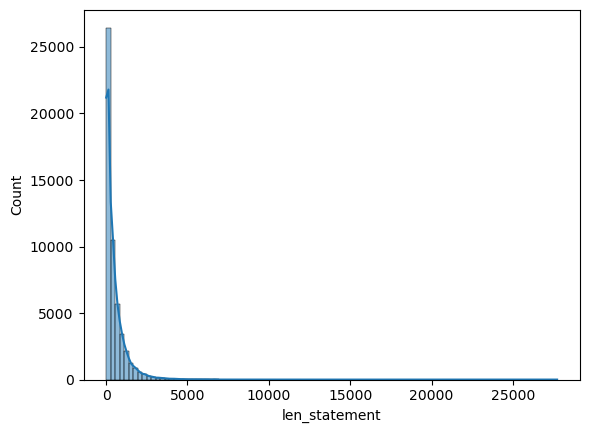

In [12]:
sns.histplot(df['len_statement'], kde=True, bins=100)

<Axes: xlabel='len_statement', ylabel='Count'>

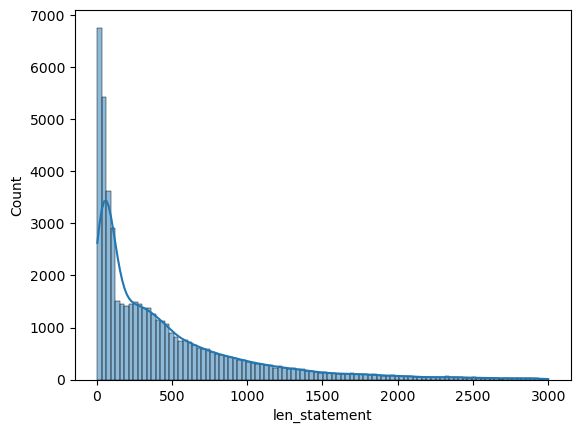

In [13]:
sns.histplot(df['len_statement'].loc[df['len_statement'] < 3000], kde=True, bins=100)

В данном случае было решено оставить строки с длиной предложения до 2500 символов:

In [14]:
df = df.loc[df['len_statement'] <= 2500].reset_index(drop=True)
df['status'].value_counts()

status
Normal                  16011
Depression              14854
Suicidal                10336
Anxiety                  3740
Bipolar                  2689
Stress                   2555
Personality disorder     1040
Name: count, dtype: int64

In [15]:
original_len = len(pd.read_csv('Combined Data.csv'))
print(f'Удалено из датасета: {original_len - len(df)} строк ({round(100 * (original_len - len(df)) / original_len, 2)}%)')

Удалено из датасета: 1818 строк (3.43%)


**5. Преобразования категориальных данных в числа**

In [16]:
le = LabelEncoder()
df['status_code'] = le.fit_transform(df['status'])
df.head()

,statement,status,cleared_statement,stemmed_tokens,len_statement,words_count,status_code
0,oh my gosh,Anxiety,oh my gosh,"[oh, my, gosh]",10,3,0
1,"trouble sleeping, confused mind, restless hear...",Anxiety,troubl sleep confus mind restless heart all ou...,"[troubl, sleep, confus, mind, restless, heart,...",55,10,0
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",73,13,0
3,I've shifted my focus to something else but I'...,Anxiety,have shift my focu to someth els but am still ...,"[have, shift, my, focu, to, someth, els, but, ...",51,11,0
4,"I'm restless and restless, it's been a month n...",Anxiety,am restless and restless it been month now boy...,"[am, restless, and, restless, it, been, month,...",63,13,0


In [17]:
df['status'].value_counts()

status
Normal                  16011
Depression              14854
Suicidal                10336
Anxiety                  3740
Bipolar                  2689
Stress                   2555
Personality disorder     1040
Name: count, dtype: int64

# 2. Подготовка данных для обучения

Перед началом обучения данные необходимо подготовить. Они будут преобразованы в тензоры.

In [18]:
class CustomDataset(Dataset):
    def __init__(self, vocab, classes, max_len, X, y):
        self.vocab = vocab
        self.max_len = max_len
        self.classes = classes

        self.text = X
        self.tokenized_text = torch.tensor([self.text_to_sequence(x) for x in X], dtype=torch.long)
        self.status = y

    def __len__(self):
        return self.status.shape[0]

    def __getitem__(self, idx):
        x = self.tokenized_text[idx]
        y = np.zeros(len(self.classes))
        y[self.classes.index(self.status[idx])] = 1
        y = torch.from_numpy(y)
        return x, y

    def text_to_sequence(self, text):
        tokens = [self.vocab.get(word, 0) for word in text]
        return tokens + [0] * (self.max_len - len(tokens))

In [19]:
def get_vocab(df):
    all_words = [word for step in [steps for steps in df.values] for word in step]
    vocab = {word: i + 2 for i, word in enumerate(Counter(all_words).keys())}
    vocab['<PAD>'] = 0
    vocab['<NAN>'] = 1

    max_len = max(df.apply(lambda x: len(x)))

    return vocab, max_len

In [20]:
vocab, max_len = get_vocab(df['stemmed_tokens'])
classes = list(set(df['status'].values))
vocab_size = len(vocab)

In [21]:
X = df['stemmed_tokens'].values
y = df['status'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.175, random_state=42)

In [22]:
BATCH_SIZE = 256

train_dataset = CustomDataset(vocab, classes, max_len, X_train, y_train)
val_dataset = CustomDataset(vocab, classes, max_len, X_val, y_val)
test_dataset = CustomDataset(vocab, classes, max_len, X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
print(f'train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}')

train: 35921, val: 7620, test: 7684


# 3. Baseline-модель

Разделение данных на train и test:

In [ ]:
X = df['cleared_statement']
y = df['status_code'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Для векторизации текста использовался TfidfVectorizer:

In [ ]:
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_train_tfidf.shape, y_train.shape

((40980, 32843), (40980,))

Для начала можно можно рассмотреть **классические модели ML**. Было выбрано 2 варианта - модель случайного леса и логистическая регрессия.

Кроме того, на этом этапе будет определена **baseline-модель**.

## RandomForestClassifier

In [ ]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_tfidf, y_train)

clf_rf.score(X_test_tfidf, y_test)

0.6683260126891166

In [ ]:
y_pred = clf_rf.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.39      0.55       736
           1       0.99      0.30      0.46       528
           2       0.52      0.82      0.63      2967
           3       0.81      0.94      0.87      3261
           4       1.00      0.29      0.45       215
           5       0.99      0.18      0.30       537
           6       0.66      0.37      0.47      2001

    accuracy                           0.67     10245
   macro avg       0.84      0.47      0.53     10245
weighted avg       0.73      0.67      0.64     10245



## LogisticRegression

In [ ]:
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train_tfidf, y_train)

clf_lr.score(X_test_tfidf, y_test)

0.7576378721327477

In [ ]:
y_pred = clf_lr.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.74      0.77       736
           1       0.87      0.66      0.75       528
           2       0.68      0.73      0.70      2967
           3       0.86      0.95      0.90      3261
           4       0.84      0.41      0.55       215
           5       0.72      0.42      0.53       537
           6       0.67      0.64      0.65      2001

    accuracy                           0.76     10245
   macro avg       0.78      0.65      0.69     10245
weighted avg       0.76      0.76      0.75     10245



Логистическая регрессия в данном случае уже показывает хороший результат. Эту модель можно использовать в качестве baseline-модели.

# 4. RNN

Следующим вариант решения задачи - использование **рекуррентной нейронной сети**. Для начала можно использовать нейронную сеть с одним рекуррентным слоем, будут рассмотрены разные слои (LSTM, GRU и RNN).

Обучение будет длиться 5 эпох. В качестве функции потерь используется кросс-энтропия. В качестве метрики используется процент верных предсказаний моделью относительно общего числа значений.

## Model

In [24]:
def train_model(model, optimizer, criterion, train_loader, test_loader, epochs=10, print_epoch=1, return_info=True):
    loss_train, loss_test = 0, 0
    acc_train, acc_test = 0, 0
    len_train, len_test = 0, 0
    start_train = time.time()

    for epoch in range(1, epochs+1):
        start_epoch = time.time()
        model.train()

        for x, y in train_loader:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
            acc_train += sum(torch.max(y_pred.data, 1)[1] == torch.max(y.data, 1)[1])
            len_train += len(x)

        if epoch % print_epoch == 0:
            model.eval()
            for x, y in test_loader:
                y_pred = model(x)
                loss = criterion(y_pred, y)

                loss_test += loss.item()
                acc_test += sum(torch.max(y_pred.data, 1)[1] == torch.max(y.data, 1)[1])
                len_test += len(x)

            print(f'Epoch {epoch} ({round(time.time() - start_epoch, 2)}s):')
            print(f'    train loss: {round(loss_train / len_train, 4)}, val loss: {round(loss_test / len_test, 4)}')
            print(f'    train accuracy: {round(100 * acc_train.detach().numpy() / len_train, 2)}%, val accuracy: {round(100 * acc_test.detach().numpy() / len_test, 2)}%')

    end_train = round(time.time() - start_train, 2)
    loss_train = round(loss_train / len_train, 4)
    acc_train = round(acc_train.detach().numpy() / len_train, 4)

    if return_info: return loss_train, acc_train, end_train


In [25]:
df_results = pd.DataFrame(columns=['model', 'epochs', 'train loss', 'train accuracy', 'test accuracy', 'time'])

def predict(model, text, vocab, max_len):
    text = text_stemmer(text.lower())
    tokens = [vocab.get(word, 0) for word in text]
    tokens = tokens + [0] * (max_len - len(tokens))
    tokens = torch.tensor(tokens, dtype=torch.long)

    model.eval()
    y_pred = model(tokens.unsqueeze(0))
    prediction = torch.max(y_pred.data, 1)[1]

    return prediction


def rnn_prediction(df, model, n):
    for i in range(n):
        idx = random.randint(0, len(df))
        statement = df['statement'].values[idx]

        print(i+1)
        print(statement)
        print(f'    - real: {df['status'].values[idx]}')
        print(f'    - predict: {classes[predict(model, statement, vocab, max_len)]}\n')


def test_accuracy(model, test_loader, print_acc=False):
    acc, i = 0, 0

    model.eval()
    for x, y in test_loader:
        y_pred = model(x)
        acc += sum(torch.max(y_pred.data, 1)[1] == torch.max(y.data, 1)[1])
        i += len(y)

    acc = acc.detach().numpy()/i
    if print_acc: print(f'test accuracy = {acc}')
    return round(acc, 4)


def train(model, model_name, optimizer, criterion, train_loader, val_loader, test_loader, epochs, print_epoch, add_row=True):
    res = train_model(model, optimizer, criterion, train_loader, val_loader, epochs, print_epoch)
    if add_row:
        test_acc = test_accuracy(model, test_loader)
        df_results.loc[len(df_results)] = [model_name, epochs, res[0], res[1], test_acc, res[2]]

In [26]:
class RNN_model(nn.Module):
    def __init__(self, rnnClass, vocab_size, embedding_size, output_size, num_hidden, max_len, drop=0.5, num_layers=1):
        super().__init__()
        self.embd = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.rnn = rnnClass(embedding_size, num_hidden, num_layers=num_layers)
        self.drop = nn.Dropout(drop)
        self.linear = nn.Linear(num_hidden * max_len, output_size)

    def forward(self, x):
        x = self.embd(x)
        output, _ = self.rnn(x)
        output = self.drop(output)
        output = output.flatten(start_dim=1, end_dim=-1)
        output = self.linear(output)

        return output

In [27]:
LR = 0.001
NUM_HIDDEN = 64
EMBEDDING_SIZE = 128
DROP = 0.3
EPOCHS = 5
PRINT_EPOCH = 1

## Train

**torch.nn.LSTM**

In [ ]:
model_lstm = RNN_model(nn.LSTM, vocab_size, EMBEDDING_SIZE, len(classes), NUM_HIDDEN, max_len, drop=DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=LR)

train(model_lstm, 'LSTM', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (193.71s):
    train loss: 0.005, val loss: 0.0042
    train accuracy: 52.09%, val accuracy: 59.5%
Epoch 2 (198.3s):
    train loss: 0.0043, val loss: 0.0039
    train accuracy: 59.18%, val accuracy: 62.3%
Epoch 3 (2119.55s):
    train loss: 0.0038, val loss: 0.0038
    train accuracy: 64.02%, val accuracy: 63.85%
Epoch 4 (1129.66s):
    train loss: 0.0034, val loss: 0.0037
    train accuracy: 67.51%, val accuracy: 65.0%
Epoch 5 (189.9s):
    train loss: 0.0032, val loss: 0.0036
    train accuracy: 70.12%, val accuracy: 65.88%


In [ ]:
rnn_prediction(df, model_lstm, n=3)

1
As she was leaving she told me "now I have to go back there again" as she was sobbing. I didnt know what to say or what I could do to help. Everyone I've talked with as told me I should've gotten her phone number because looking her phone number up through our receipts and membership files is an invasion of privacy. Did I miss my only opportunity to help her by not asking for her phone number? Sorry for the sad story, I just don't know what to do and it's painful to think what is happening to her right now.
    - real: Stress
    - predict: Normal

2
what are you going to do about your death?
    - real: Normal
    - predict: Normal

3
How much do you currently spend per month on your mental health medications? Monthly cost of mental health medications?
    - real: Depression
    - predict: Anxiety



**torch.nn.RNN**

In [ ]:
model_rnn = RNN_model(nn.RNN, vocab_size, EMBEDDING_SIZE, len(classes), NUM_HIDDEN, max_len, drop=DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=LR)

train(model_rnn, 'RNN', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (968.96s):
    train loss: 0.0051, val loss: 0.0044
    train accuracy: 52.3%, val accuracy: 58.79%
Epoch 2 (225.46s):
    train loss: 0.0043, val loss: 0.0042
    train accuracy: 59.78%, val accuracy: 60.62%
Epoch 3 (68.44s):
    train loss: 0.0038, val loss: 0.0041
    train accuracy: 64.13%, val accuracy: 61.61%
Epoch 4 (68.02s):
    train loss: 0.0035, val loss: 0.0041
    train accuracy: 67.23%, val accuracy: 62.36%
Epoch 5 (68.06s):
    train loss: 0.0032, val loss: 0.0041
    train accuracy: 69.63%, val accuracy: 63.02%


In [ ]:
rnn_prediction(df, model_rnn, n=3)

1
No, I will not "keep holding on". I do not see anything that could make me to. Why all the effort? what is it all for? Nothing, just eternal struggle. The further I get, the narrower the tunnel gets, only one option remains. it is all death anyway, why wait? it is so comforting to even think about it. Just eternal peace, blackness, nothing. As it was before I came here. Please, do not spit me out to this reality again. How is holding on preferable to just letting go? what is there at the end that is so worth it?
    - real: Suicidal
    - predict: Suicidal

2
I spent three years committing to who I thought was my soulmate, she was so integrated into my life there was not a part of my life that she was not a part of.She and I broke up, because she was afraid of long distance over the next few months, and felt we were growing apart.She left, and I am glad she is doing well and has a life without me, but my life is empty, it has always been. I have no friends, I work remotely, live in m

**torch.nn.GRU**

In [ ]:
model_gru = RNN_model(nn.GRU, vocab_size, EMBEDDING_SIZE, len(classes), NUM_HIDDEN, max_len, drop=DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gru.parameters(), lr=LR)

train(model_gru, 'GRU', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (4012.51s):
    train loss: 0.0051, val loss: 0.0043
    train accuracy: 51.46%, val accuracy: 58.6%
Epoch 2 (2028.28s):
    train loss: 0.0043, val loss: 0.0041
    train accuracy: 58.72%, val accuracy: 60.58%
Epoch 3 (160.23s):
    train loss: 0.0039, val loss: 0.0039
    train accuracy: 63.38%, val accuracy: 61.99%
Epoch 4 (1025.7s):
    train loss: 0.0035, val loss: 0.0039
    train accuracy: 66.66%, val accuracy: 63.03%
Epoch 5 (159.99s):
    train loss: 0.0032, val loss: 0.0038
    train accuracy: 69.23%, val accuracy: 63.8%


In [ ]:
rnn_prediction(df, model_gru, n=3)

1
Adoi forgot to think what to do for the 6th anniversary mx
    - real: Normal
    - predict: Normal

2
morning all gave the cat his tablet this morning what a mission that is he know what we re up to now and prepares for battle
    - real: Normal
    - predict: Normal

3
What does it mean when I have lost all feeling possible (99% of time)? I do not react to love from my girlfriend or family at all or get happy triggers from it, i do not even cry anymore, i do not get angry at stuff (i just say fuc* it and brush it off), etc. its almost like I am just here in autopilot. Will therapy help? Meds? Nothing? Feeling numb?
    - real: Depression
    - predict: Bipolar



In [ ]:
df_results.head()

,model,epochs,train loss,train accuracy,test accuracy,time
0,LSTM,5,0.0032,0.7012,0.6951,3831.16
1,RNN,5,0.0032,0.6963,0.6573,1398.96
2,GRU,5,0.0032,0.6923,0.6726,7386.75


Лучший результат показала модель с рекуррентным слоем **LSTM**. Значение accuracy на тестовых данных получилось равным примерно **0.6951**, то есть модель выдает примерно 70% верных ответов.

**Результат меньше чем у baseline-модели**. Можно рассмотреть другие архитектуры.

## n-grams

Слудующий эксперимент будет с использованием n-грамм (биграммы, триграмм и их комбинации с униграммами).

Так как лучшие метрики для базовых RNN моделей были у LSTM, то для n-грамм будет импользован именно этот слой.

In [ ]:
def get_ngrams(text, n):
    grams = ngrams(text, n)
    new_text = [' '.join(gram) for gram in grams]

    return new_text

In [ ]:
EPOCHS = 3

df['stemmed_2grams'] = df['stemmed_tokens'].apply(lambda x: get_ngrams(x, n=2))
df['stemmed_3grams'] = df['stemmed_tokens'].apply(lambda x: get_ngrams(x, n=3))

### 2-grams

In [ ]:
vocab_ngrams, max_len_ngrams = get_vocab(df['stemmed_2grams'])
vocab_size_ngrams = len(vocab_ngrams)

X_ngrams = df['stemmed_2grams'].values
y = df['status'].values

X_train_ngrams, X_test_ngrams, y_train_ngrams, y_test_ngrams = train_test_split(X_ngrams, y, test_size=0.15, random_state=42)
X_train_ngrams, X_val_ngrams, y_train_ngrams, y_val_ngrams = train_test_split(X_train_ngrams, y_train_ngrams, test_size=0.175, random_state=42)

train_loader_ngrams = DataLoader(CustomDataset(vocab_ngrams, classes, max_len_ngrams, X_train_ngrams, y_train_ngrams), batch_size=BATCH_SIZE, shuffle=True)
val_loader_ngrams = DataLoader(CustomDataset(vocab_ngrams, classes, max_len_ngrams, X_val_ngrams, y_val_ngrams), batch_size=BATCH_SIZE, shuffle=True)
test_loader_ngrams = DataLoader(CustomDataset(vocab_ngrams, classes, max_len_ngrams, X_test_ngrams, y_test_ngrams), batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model_rnn_ngrams = RNN_model(nn.LSTM, vocab_size_ngrams, EMBEDDING_SIZE, len(classes), NUM_HIDDEN, max_len_ngrams, drop=DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rnn_ngrams.parameters(), lr=0.001)

train(model_rnn_ngrams, 'LSTM (2-grams)', optimizer, criterion, train_loader_ngrams, val_loader_ngrams, test_loader_ngrams, EPOCHS, PRINT_EPOCH)

Epoch 1 (244.72s):
    train loss: 0.0053, val loss: 0.0049
    train accuracy: 49.33%, val accuracy: 52.99%
Epoch 2 (236.72s):
    train loss: 0.0048, val loss: 0.0047
    train accuracy: 54.83%, val accuracy: 54.23%
Epoch 3 (285.83s):
    train loss: 0.0043, val loss: 0.0046
    train accuracy: 60.39%, val accuracy: 55.38%


### 3-grams

In [ ]:
vocab_ngrams, max_len_ngrams = get_vocab(df['stemmed_3grams'])
vocab_size_ngrams = len(vocab_ngrams)

X_ngrams = df['stemmed_3grams'].values
y = df['status'].values

X_train_ngrams, X_test_ngrams, y_train_ngrams, y_test_ngrams = train_test_split(X_ngrams, y, test_size=0.15, random_state=42)
X_train_ngrams, X_val_ngrams, y_train_ngrams, y_val_ngrams = train_test_split(X_train_ngrams, y_train_ngrams, test_size=0.175, random_state=42)

train_loader_ngrams = DataLoader(CustomDataset(vocab_ngrams, classes, max_len_ngrams, X_train_ngrams, y_train_ngrams), batch_size=BATCH_SIZE, shuffle=True)
val_loader_ngrams = DataLoader(CustomDataset(vocab_ngrams, classes, max_len_ngrams, X_val_ngrams, y_val_ngrams), batch_size=BATCH_SIZE, shuffle=True)
test_loader_ngrams = DataLoader(CustomDataset(vocab_ngrams, classes, max_len_ngrams, X_test_ngrams, y_test_ngrams), batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model_rnn_ngrams = RNN_model(nn.LSTM, vocab_size_ngrams, EMBEDDING_SIZE, len(classes), NUM_HIDDEN, max_len_ngrams, drop=DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rnn_ngrams.parameters(), lr=0.001)

train(model_rnn_ngrams, 'LSTM (3-grams)', optimizer, criterion, train_loader_ngrams, val_loader_ngrams, test_loader_ngrams, EPOCHS, PRINT_EPOCH)

Epoch 1 (2212.58s):
    train loss: 0.0054, val loss: 0.005
    train accuracy: 49.32%, val accuracy: 51.64%
Epoch 2 (4026.06s):
    train loss: 0.0049, val loss: 0.005
    train accuracy: 54.27%, val accuracy: 51.27%
Epoch 3 (8241.95s):
    train loss: 0.0044, val loss: 0.0051
    train accuracy: 60.11%, val accuracy: 51.67%


### unigrams + 2-grams

In [ ]:
X_values = df['stemmed_tokens'] + df['stemmed_2grams']
vocab_ngrams, max_len_ngrams = get_vocab(X_values)
vocab_size_ngrams = len(vocab_ngrams)

X_ngrams = X_values.values
y = df['status'].values

X_train_ngrams, X_test_ngrams, y_train_ngrams, y_test_ngrams = train_test_split(X_ngrams, y, test_size=0.15, random_state=42)
X_train_ngrams, X_val_ngrams, y_train_ngrams, y_val_ngrams = train_test_split(X_train_ngrams, y_train_ngrams, test_size=0.175, random_state=42)

train_loader_ngrams = DataLoader(CustomDataset(vocab_ngrams, classes, max_len_ngrams, X_train_ngrams, y_train_ngrams), batch_size=BATCH_SIZE, shuffle=True)
val_loader_ngrams = DataLoader(CustomDataset(vocab_ngrams, classes, max_len_ngrams, X_val_ngrams, y_val_ngrams), batch_size=BATCH_SIZE, shuffle=True)
test_loader_ngrams = DataLoader(CustomDataset(vocab_ngrams, classes, max_len_ngrams, X_test_ngrams, y_test_ngrams), batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model_rnn_ngrams = RNN_model(nn.LSTM, vocab_size_ngrams, EMBEDDING_SIZE, len(classes), NUM_HIDDEN, max_len_ngrams, drop=DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rnn_ngrams.parameters(), lr=0.001)

train(model_rnn_ngrams, 'LSTM (1-grams, 2-grams)', optimizer, criterion, train_loader_ngrams, val_loader_ngrams, test_loader_ngrams, EPOCHS, PRINT_EPOCH)

Epoch 1 (6168.5s):
    train loss: 0.0051, val loss: 0.0044
    train accuracy: 51.72%, val accuracy: 57.43%
Epoch 2 (4209.15s):
    train loss: 0.0042, val loss: 0.0041
    train accuracy: 60.53%, val accuracy: 60.23%
Epoch 3 (6860.76s):
    train loss: 0.0036, val loss: 0.004
    train accuracy: 66.74%, val accuracy: 61.77%


### unigrams + 3-grams

In [ ]:
X_values = df['stemmed_tokens'] + df['stemmed_3grams']
vocab_ngrams, max_len_ngrams = get_vocab(X_values)
vocab_size_ngrams = len(vocab_ngrams)

X_ngrams = X_values.values
y = df['status'].values

X_train_ngrams, X_test_ngrams, y_train_ngrams, y_test_ngrams = train_test_split(X_ngrams, y, test_size=0.15, random_state=42)
X_train_ngrams, X_val_ngrams, y_train_ngrams, y_val_ngrams = train_test_split(X_train_ngrams, y_train_ngrams, test_size=0.175, random_state=42)

train_loader_ngrams = DataLoader(CustomDataset(vocab_ngrams, classes, max_len_ngrams, X_train_ngrams, y_train_ngrams), batch_size=BATCH_SIZE, shuffle=True)
val_loader_ngrams = DataLoader(CustomDataset(vocab_ngrams, classes, max_len_ngrams, X_val_ngrams, y_val_ngrams), batch_size=BATCH_SIZE, shuffle=True)
test_loader_ngrams = DataLoader(CustomDataset(vocab_ngrams, classes, max_len_ngrams, X_test_ngrams, y_test_ngrams), batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model_rnn_ngrams = RNN_model(nn.LSTM, vocab_size_ngrams, EMBEDDING_SIZE, len(classes), NUM_HIDDEN, max_len_ngrams, drop=DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rnn_ngrams.parameters(), lr=0.001)

train(model_rnn_ngrams, 'LSTM (1-grams, 3-grams)', optimizer, criterion, train_loader_ngrams, val_loader_ngrams, test_loader_ngrams, EPOCHS, PRINT_EPOCH)

Epoch 1 (14174.41s):
    train loss: 0.0051, val loss: 0.0044
    train accuracy: 51.28%, val accuracy: 57.65%
Epoch 2 (4322.28s):
    train loss: 0.0042, val loss: 0.0041
    train accuracy: 60.62%, val accuracy: 60.55%
Epoch 3 (1535.43s):
    train loss: 0.0035, val loss: 0.004
    train accuracy: 67.54%, val accuracy: 62.0%


In [ ]:
df_results.head(10)

,model,epochs,train loss,train accuracy,test accuracy,time
0,LSTM,5,0.0032,0.7012,0.6951,3831.16
1,RNN,5,0.0032,0.6963,0.6573,1398.96
2,GRU,5,0.0032,0.6923,0.6726,7386.75
3,LSTM (2-grams),3,0.0043,0.6039,0.5709,767.33
4,LSTM (3-grams),3,0.0044,0.6011,0.5182,14480.75
5,"LSTM (1-grams, 2-grams)",3,0.0036,0.6674,0.6499,17238.48
6,"LSTM (1-grams, 3-grams)",3,0.0035,0.6754,0.6525,20032.23


Метрики в данном случае после 3й эпохи почти не отличаются от варианта с использованием только униграмм. При этом время обучения выросло в несколько раз.

# 5. CNN

## 1 сверточный слой

In [ ]:
class CNN_model(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_filters, filter_size, output_size, drop=0.2):
        super().__init__()
        self.embd = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.conv = nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(filter_size, embedding_size))
        self.drop = nn.Dropout(drop)
        self.linear = nn.Linear(num_filters, output_size)

    def forward(self, x):
        x = self.embd(x).unsqueeze(1)
        output = self.conv(x).squeeze(3)
        output = torch.max(output, dim=2)[0]
        output = self.drop(output)
        output = self.linear(output)
        return output

In [ ]:
LR = 0.001
NUM_HIDDEN = 64
EMBEDDING_SIZE = 128
DROP = 0.3
EPOCHS = 5
PRINT_EPOCH = 1
NUM_FILTERS = 100

### Размер фильтра (1, 2, 3, 4, 5, 10)

In [ ]:
FILTER_SIZE = 1

model_cnn = CNN_model(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (kernel_size=1)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (56.47s):
    train loss: 0.0056, val loss: 0.0041
    train accuracy: 50.3%, val accuracy: 63.28%
Epoch 2 (51.58s):
    train loss: 0.0049, val loss: 0.0038
    train accuracy: 55.93%, val accuracy: 65.96%
Epoch 3 (49.07s):
    train loss: 0.0045, val loss: 0.0036
    train accuracy: 59.01%, val accuracy: 67.27%
Epoch 4 (49.41s):
    train loss: 0.0043, val loss: 0.0035
    train accuracy: 60.97%, val accuracy: 68.35%
Epoch 5 (48.02s):
    train loss: 0.0041, val loss: 0.0034
    train accuracy: 62.36%, val accuracy: 69.27%


In [ ]:
FILTER_SIZE = 2

model_cnn = CNN_model(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (kernel_size=2)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (79.92s):
    train loss: 0.0055, val loss: 0.004
    train accuracy: 49.83%, val accuracy: 64.55%
Epoch 2 (82.99s):
    train loss: 0.0049, val loss: 0.0037
    train accuracy: 56.07%, val accuracy: 67.22%
Epoch 3 (81.53s):
    train loss: 0.0045, val loss: 0.0035
    train accuracy: 59.49%, val accuracy: 68.59%
Epoch 4 (82.23s):
    train loss: 0.0042, val loss: 0.0034
    train accuracy: 61.74%, val accuracy: 69.49%
Epoch 5 (82.57s):
    train loss: 0.004, val loss: 0.0032
    train accuracy: 63.36%, val accuracy: 70.38%


In [ ]:
FILTER_SIZE = 3

model_cnn = CNN_model(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (kernel_size=3)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (122.85s):
    train loss: 0.0055, val loss: 0.004
    train accuracy: 50.33%, val accuracy: 64.62%
Epoch 2 (117.0s):
    train loss: 0.0048, val loss: 0.0037
    train accuracy: 56.73%, val accuracy: 67.37%
Epoch 3 (119.16s):
    train loss: 0.0044, val loss: 0.0035
    train accuracy: 60.13%, val accuracy: 68.72%
Epoch 4 (119.68s):
    train loss: 0.0041, val loss: 0.0034
    train accuracy: 62.42%, val accuracy: 69.81%
Epoch 5 (117.59s):
    train loss: 0.0039, val loss: 0.0033
    train accuracy: 64.1%, val accuracy: 70.53%


In [ ]:
FILTER_SIZE = 4

model_cnn = CNN_model(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (kernel_size=4)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (159.23s):
    train loss: 0.0055, val loss: 0.0039
    train accuracy: 50.46%, val accuracy: 65.46%
Epoch 2 (151.42s):
    train loss: 0.0047, val loss: 0.0036
    train accuracy: 57.13%, val accuracy: 67.98%
Epoch 3 (153.56s):
    train loss: 0.0043, val loss: 0.0034
    train accuracy: 60.65%, val accuracy: 69.17%
Epoch 4 (155.7s):
    train loss: 0.004, val loss: 0.0033
    train accuracy: 63.06%, val accuracy: 70.07%
Epoch 5 (151.66s):
    train loss: 0.0038, val loss: 0.0032
    train accuracy: 64.78%, val accuracy: 70.72%


In [ ]:
FILTER_SIZE = 5

model_cnn = CNN_model(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (kernel_size=5)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (175.74s):
    train loss: 0.0055, val loss: 0.0039
    train accuracy: 50.87%, val accuracy: 65.55%
Epoch 2 (176.21s):
    train loss: 0.0047, val loss: 0.0036
    train accuracy: 57.35%, val accuracy: 68.01%
Epoch 3 (177.16s):
    train loss: 0.0043, val loss: 0.0034
    train accuracy: 60.84%, val accuracy: 69.4%
Epoch 4 (178.11s):
    train loss: 0.004, val loss: 0.0033
    train accuracy: 63.26%, val accuracy: 70.22%
Epoch 5 (177.72s):
    train loss: 0.0038, val loss: 0.0032
    train accuracy: 65.1%, val accuracy: 70.89%


In [ ]:
FILTER_SIZE = 10

model_cnn = CNN_model(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (kernel_size=10)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (337.42s):
    train loss: 0.0054, val loss: 0.0039
    train accuracy: 51.99%, val accuracy: 64.96%
Epoch 2 (351.62s):
    train loss: 0.0046, val loss: 0.0036
    train accuracy: 58.68%, val accuracy: 67.24%
Epoch 3 (349.88s):
    train loss: 0.0041, val loss: 0.0034
    train accuracy: 62.42%, val accuracy: 68.58%
Epoch 4 (338.97s):
    train loss: 0.0038, val loss: 0.0033
    train accuracy: 65.1%, val accuracy: 69.4%
Epoch 5 (332.9s):
    train loss: 0.0036, val loss: 0.0032
    train accuracy: 67.32%, val accuracy: 69.99%


In [ ]:
df_results.tail(6)

,model,epochs,train loss,train accuracy,test accuracy,time
7,CNN (kernel_size=1),5,0.0041,0.6236,0.7290,254.56
8,CNN (kernel_size=2),5,0.0040,0.6336,0.7419,409.25
9,CNN (kernel_size=3),5,0.0039,0.6410,0.7344,596.29
10,CNN (kernel_size=4),5,0.0038,0.6478,0.7409,771.58
11,CNN (kernel_size=5),5,0.0038,0.6510,0.7305,884.94
12,CNN (kernel_size=10),5,0.0036,0.6732,0.7305,1710.82


В данном слечае значение FILTER_SIZE не особо влияет на результат метрики для тестовых данных, поэтому для дальнейших экспериментов можно использовать небольшое значение, чтобы сократить время обучения модели.

In [ ]:
FILTER_SIZE = 2

### Количество фильтров (50, 200, 500, 1000)

In [ ]:
NUM_FILTERS = 50

model_cnn = CNN_model(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (num_filters=50)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (108.13s):
    train loss: 0.006, val loss: 0.0044
    train accuracy: 46.21%, val accuracy: 62.36%
Epoch 2 (119.02s):
    train loss: 0.0052, val loss: 0.004
    train accuracy: 53.51%, val accuracy: 65.25%
Epoch 3 (115.07s):
    train loss: 0.0048, val loss: 0.0038
    train accuracy: 57.08%, val accuracy: 66.92%
Epoch 4 (120.96s):
    train loss: 0.0045, val loss: 0.0037
    train accuracy: 59.45%, val accuracy: 68.02%
Epoch 5 (111.08s):
    train loss: 0.0043, val loss: 0.0035
    train accuracy: 61.11%, val accuracy: 68.77%


In [ ]:
NUM_FILTERS = 200

model_cnn = CNN_model(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (num_filters=200)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (183.88s):
    train loss: 0.0052, val loss: 0.0038
    train accuracy: 53.27%, val accuracy: 65.66%
Epoch 2 (183.41s):
    train loss: 0.0045, val loss: 0.0034
    train accuracy: 59.48%, val accuracy: 68.73%
Epoch 3 (161.49s):
    train loss: 0.0041, val loss: 0.0033
    train accuracy: 62.77%, val accuracy: 69.95%
Epoch 4 (162.81s):
    train loss: 0.0038, val loss: 0.0031
    train accuracy: 64.97%, val accuracy: 71.07%
Epoch 5 (168.99s):
    train loss: 0.0036, val loss: 0.003
    train accuracy: 66.7%, val accuracy: 71.86%


In [ ]:
NUM_FILTERS = 500

model_cnn = CNN_model(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (num_filters=500)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (314.36s):
    train loss: 0.0048, val loss: 0.0033
    train accuracy: 56.21%, val accuracy: 70.14%
Epoch 2 (328.24s):
    train loss: 0.0041, val loss: 0.0031
    train accuracy: 62.5%, val accuracy: 71.48%
Epoch 3 (322.43s):
    train loss: 0.0037, val loss: 0.003
    train accuracy: 65.82%, val accuracy: 72.31%
Epoch 4 (315.61s):
    train loss: 0.0034, val loss: 0.0029
    train accuracy: 68.09%, val accuracy: 73.0%
Epoch 5 (315.51s):
    train loss: 0.0032, val loss: 0.0028
    train accuracy: 69.75%, val accuracy: 73.27%


In [ ]:
NUM_FILTERS = 1000

model_cnn = CNN_model(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (num_filters=1000)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (546.1s):
    train loss: 0.0048, val loss: 0.0033
    train accuracy: 56.9%, val accuracy: 70.68%
Epoch 2 (540.25s):
    train loss: 0.004, val loss: 0.0031
    train accuracy: 63.65%, val accuracy: 71.65%
Epoch 3 (541.1s):
    train loss: 0.0036, val loss: 0.003
    train accuracy: 67.23%, val accuracy: 72.79%
Epoch 4 (540.91s):
    train loss: 0.0033, val loss: 0.0029
    train accuracy: 69.71%, val accuracy: 73.55%
Epoch 5 (535.36s):
    train loss: 0.003, val loss: 0.0028
    train accuracy: 71.63%, val accuracy: 74.1%


In [ ]:
df_results.tail(4)

,model,epochs,train loss,train accuracy,test accuracy,time
13,CNN (num_filters=50),5,0.0043,0.6111,0.7199,574.28
14,CNN (num_filters=200),5,0.0036,0.6670,0.7493,860.61
15,CNN (num_filters=500),5,0.0032,0.6975,0.7478,1596.18
16,CNN (num_filters=1000),5,0.0030,0.7163,0.7694,2703.76


В случае с количеством фильтров - чем больше фильтров, тем выше метрика. Но сильно увеличивается время обучения, поэтому дальнейшие эксперименты буду проводиться небольшом числе фильтров, а положительно влияние на метрики большего числа пока что просто учтем.

## Несколько сверточных слев

In [28]:
class CNN_model_v2(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_filters, filter_size, output_size, drop=0.2):
        super().__init__()
        self.embd = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.conv = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(n, embedding_size))
            for n in filter_size])
        self.drop = nn.Dropout(drop)
        self.linear = nn.Linear(num_filters * len(filter_size), output_size)

    def forward(self, x):
        x = self.embd(x).unsqueeze(1)
        output = [torch.relu(conv(x)).squeeze(3) for conv in self.conv]
        output = [torch.max(conv, dim=2)[0] for conv in output]
        output = torch.cat(output, dim=1)
        output = self.drop(output)
        output = self.linear(output)
        return output

In [ ]:
LR = 0.001
NUM_HIDDEN = 64
EMBEDDING_SIZE = 128
DROP = 0.3
EPOCHS = 5
PRINT_EPOCH = 1
NUM_FILTERS = 100
FILTER_SIZE = 3

In [ ]:
FILTER_SIZE = [1, 2]

model_cnn = CNN_model_v2(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (2-layers: 1,2)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (134.95s):
    train loss: 0.0052, val loss: 0.0037
    train accuracy: 53.22%, val accuracy: 66.47%
Epoch 2 (142.25s):
    train loss: 0.0045, val loss: 0.0034
    train accuracy: 59.33%, val accuracy: 68.89%
Epoch 3 (143.32s):
    train loss: 0.0041, val loss: 0.0032
    train accuracy: 62.49%, val accuracy: 70.31%
Epoch 4 (141.37s):
    train loss: 0.0039, val loss: 0.0031
    train accuracy: 64.51%, val accuracy: 71.3%
Epoch 5 (132.88s):
    train loss: 0.0037, val loss: 0.003
    train accuracy: 65.93%, val accuracy: 71.99%


In [ ]:
FILTER_SIZE = [1, 3]

model_cnn = CNN_model_v2(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (2-layers: 1,3)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (167.99s):
    train loss: 0.0051, val loss: 0.0036
    train accuracy: 53.78%, val accuracy: 68.7%
Epoch 2 (167.42s):
    train loss: 0.0044, val loss: 0.0033
    train accuracy: 59.89%, val accuracy: 70.28%
Epoch 3 (182.83s):
    train loss: 0.004, val loss: 0.0032
    train accuracy: 62.97%, val accuracy: 70.93%
Epoch 4 (176.83s):
    train loss: 0.0038, val loss: 0.0031
    train accuracy: 64.97%, val accuracy: 71.7%
Epoch 5 (198.18s):
    train loss: 0.0036, val loss: 0.003
    train accuracy: 66.45%, val accuracy: 72.43%


In [ ]:
FILTER_SIZE = [1, 2, 3]

model_cnn = CNN_model_v2(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (3-layers: 1,2,3)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (266.44s):
    train loss: 0.005, val loss: 0.0035
    train accuracy: 54.81%, val accuracy: 67.86%
Epoch 2 (251.3s):
    train loss: 0.0043, val loss: 0.0033
    train accuracy: 60.88%, val accuracy: 70.12%
Epoch 3 (259.16s):
    train loss: 0.0039, val loss: 0.0031
    train accuracy: 63.97%, val accuracy: 71.3%
Epoch 4 (268.47s):
    train loss: 0.0037, val loss: 0.003
    train accuracy: 66.05%, val accuracy: 72.23%
Epoch 5 (256.3s):
    train loss: 0.0035, val loss: 0.0029
    train accuracy: 67.59%, val accuracy: 72.94%


In [ ]:
FILTER_SIZE = [1, 2, 3, 4]

model_cnn = CNN_model_v2(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (4-layers: 1,2,3,4)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (402.75s):
    train loss: 0.0049, val loss: 0.0034
    train accuracy: 56.44%, val accuracy: 68.45%
Epoch 2 (407.62s):
    train loss: 0.0042, val loss: 0.0032
    train accuracy: 62.22%, val accuracy: 70.8%
Epoch 3 (436.52s):
    train loss: 0.0038, val loss: 0.003
    train accuracy: 65.33%, val accuracy: 72.23%
Epoch 4 (437.67s):
    train loss: 0.0035, val loss: 0.0029
    train accuracy: 67.49%, val accuracy: 73.07%
Epoch 5 (428.32s):
    train loss: 0.0033, val loss: 0.0028
    train accuracy: 69.08%, val accuracy: 73.63%


In [ ]:
FILTER_SIZE = [1, 2, 3, 4, 5]

model_cnn = CNN_model_v2(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (5-layers: 1,2,3,4,5)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (602.38s):
    train loss: 0.0048, val loss: 0.0034
    train accuracy: 56.17%, val accuracy: 68.88%
Epoch 2 (685.87s):
    train loss: 0.0041, val loss: 0.0031
    train accuracy: 62.32%, val accuracy: 71.05%
Epoch 3 (1740.45s):
    train loss: 0.0037, val loss: 0.003
    train accuracy: 65.71%, val accuracy: 72.45%
Epoch 4 (714.13s):
    train loss: 0.0034, val loss: 0.0029
    train accuracy: 67.93%, val accuracy: 73.26%
Epoch 5 (2164.13s):
    train loss: 0.0032, val loss: 0.0028
    train accuracy: 69.72%, val accuracy: 73.81%


In [ ]:
df_results.tail(5)

,model,epochs,train loss,train accuracy,test accuracy,time
17,"CNN (2-layers: 1,2)",5,0.0037,0.6593,0.7483,694.82
18,"CNN (2-layers: 1,3)",5,0.0036,0.6645,0.7572,893.26
19,"CNN (3-layers: 1,2,3)",5,0.0035,0.6759,0.7599,1301.75
20,"CNN (4-layers: 1,2,3,4)",5,0.0033,0.6908,0.7660,2112.99
21,"CNN (4-layers: 1,2,3,4,5)",5,0.0032,0.6972,0.7698,5907.06


Увеличение количества слоев несильно, но увеличивает значение метрики на тестовых данных. Кроме того, в данном случае лучше видно, какие именно n-граммы влияют на результат. Например, биграммы менее информативны для модели в отличие от триграмм.

### Добавление слоя BatchNorm

In [29]:
class CNN_model_v2(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_filters, filter_size, output_size, drop=0.2):
        super().__init__()
        self.embd = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.conv = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(n, embedding_size))
            for n in filter_size])
        self.batchnorm = nn.BatchNorm1d(num_filters * len(filter_size))
        self.drop = nn.Dropout(drop)
        self.linear = nn.Linear(num_filters * len(filter_size), output_size)

    def forward(self, x):
        x = self.embd(x).unsqueeze(1)
        output = [torch.relu(conv(x)).squeeze(3) for conv in self.conv]
        output = [torch.max(conv, dim=2)[0] for conv in output]
        output = torch.cat(output, dim=1)
        output = self.batchnorm(output)
        output = self.drop(output)
        output = self.linear(output)
        return output

In [ ]:
FILTER_SIZE = [2]

model_cnn = CNN_model_v2(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (1-layer, batchnorm)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (84.59s):
    train loss: 0.0048, val loss: 0.0034
    train accuracy: 57.02%, val accuracy: 70.52%
Epoch 2 (83.22s):
    train loss: 0.004, val loss: 0.0032
    train accuracy: 63.44%, val accuracy: 71.92%
Epoch 3 (98.01s):
    train loss: 0.0037, val loss: 0.003
    train accuracy: 66.46%, val accuracy: 72.83%
Epoch 4 (94.43s):
    train loss: 0.0035, val loss: 0.0029
    train accuracy: 68.42%, val accuracy: 73.35%
Epoch 5 (91.23s):
    train loss: 0.0033, val loss: 0.0029
    train accuracy: 69.87%, val accuracy: 73.69%


In [ ]:
df_results.iloc[[8, 22]]

,model,epochs,train loss,train accuracy,test accuracy,time
8,CNN (kernel_size=2),5,0.0040,0.6336,0.7419,409.25
22,"CNN (1-layer, batchnorm)",5,0.0033,0.6987,0.7479,451.54


In [ ]:
FILTER_SIZE = [1, 2, 3]

model_cnn = CNN_model_v2(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (3-layers, batchnorm)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (233.35s):
    train loss: 0.0043, val loss: 0.0031
    train accuracy: 61.67%, val accuracy: 72.44%
Epoch 2 (253.14s):
    train loss: 0.0036, val loss: 0.0029
    train accuracy: 67.25%, val accuracy: 73.75%
Epoch 3 (244.8s):
    train loss: 0.0032, val loss: 0.0028
    train accuracy: 70.27%, val accuracy: 74.53%
Epoch 4 (247.52s):
    train loss: 0.003, val loss: 0.0027
    train accuracy: 72.37%, val accuracy: 75.1%
Epoch 5 (233.07s):
    train loss: 0.0028, val loss: 0.0027
    train accuracy: 74.09%, val accuracy: 75.35%


In [ ]:
df_results.iloc[[19, 23]]

,model,epochs,train loss,train accuracy,test accuracy,time
19,"CNN (3-layers: 1,2,3)",5,0.0035,0.6759,0.7599,1301.75
23,"CNN (3-layers, batchnorm)",5,0.0028,0.7409,0.7625,1211.91


Добавление слоя BatchNorm хорошо повлияло на метрики.

### Изменение значения Dropout

In [ ]:
FILTER_SIZE = [1, 2, 3]
DROP = 0.0

model_cnn = CNN_model_v2(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (3-layers, drop=0)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (230.44s):
    train loss: 0.004, val loss: 0.003
    train accuracy: 64.27%, val accuracy: 72.52%
Epoch 2 (1918.85s):
    train loss: 0.0033, val loss: 0.0028
    train accuracy: 70.08%, val accuracy: 73.84%
Epoch 3 (223.89s):
    train loss: 0.0029, val loss: 0.0027
    train accuracy: 73.71%, val accuracy: 74.55%
Epoch 4 (239.9s):
    train loss: 0.0026, val loss: 0.0027
    train accuracy: 76.56%, val accuracy: 74.79%
Epoch 5 (239.13s):
    train loss: 0.0023, val loss: 0.0027
    train accuracy: 79.04%, val accuracy: 74.95%


In [ ]:
FILTER_SIZE = [1, 2, 3]
DROP = 0.1

model_cnn = CNN_model_v2(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (3-layers, drop=0.1)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (243.52s):
    train loss: 0.004, val loss: 0.0029
    train accuracy: 64.68%, val accuracy: 73.6%
Epoch 2 (245.81s):
    train loss: 0.0033, val loss: 0.0028
    train accuracy: 70.01%, val accuracy: 74.44%
Epoch 3 (245.18s):
    train loss: 0.0029, val loss: 0.0027
    train accuracy: 73.15%, val accuracy: 74.99%
Epoch 4 (264.66s):
    train loss: 0.0027, val loss: 0.0027
    train accuracy: 75.65%, val accuracy: 75.35%
Epoch 5 (236.94s):
    train loss: 0.0025, val loss: 0.0026
    train accuracy: 77.72%, val accuracy: 75.49%


In [ ]:
FILTER_SIZE = [1, 2, 3]
DROP = 0.2

model_cnn = CNN_model_v2(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (3-layers, drop=0.2)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (234.5s):
    train loss: 0.0041, val loss: 0.0031
    train accuracy: 63.58%, val accuracy: 72.41%
Epoch 2 (234.64s):
    train loss: 0.0035, val loss: 0.0029
    train accuracy: 68.95%, val accuracy: 73.62%
Epoch 3 (236.42s):
    train loss: 0.0031, val loss: 0.0028
    train accuracy: 72.02%, val accuracy: 74.39%
Epoch 4 (234.04s):
    train loss: 0.0028, val loss: 0.0027
    train accuracy: 74.25%, val accuracy: 74.8%
Epoch 5 (237.65s):
    train loss: 0.0026, val loss: 0.0027
    train accuracy: 76.06%, val accuracy: 75.04%


In [ ]:
FILTER_SIZE = [1, 2, 3]
DROP = 0.5

model_cnn = CNN_model_v2(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (3-layers, drop=0.5)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (241.43s):
    train loss: 0.0045, val loss: 0.0032
    train accuracy: 60.26%, val accuracy: 70.75%
Epoch 2 (237.33s):
    train loss: 0.0038, val loss: 0.003
    train accuracy: 65.27%, val accuracy: 72.45%
Epoch 3 (239.6s):
    train loss: 0.0035, val loss: 0.0029
    train accuracy: 67.87%, val accuracy: 73.32%
Epoch 4 (242.27s):
    train loss: 0.0033, val loss: 0.0028
    train accuracy: 69.68%, val accuracy: 73.92%
Epoch 5 (238.12s):
    train loss: 0.0031, val loss: 0.0028
    train accuracy: 71.05%, val accuracy: 74.35%


In [ ]:
df_results.tail(5)

,model,epochs,train loss,train accuracy,test accuracy,time
23,"CNN (3-layers, batchnorm)",5,0.0028,0.7409,0.7625,1211.91
24,"CNN (3-layers, drop=0)",5,0.0023,0.7904,0.7518,2852.25
25,"CNN (3-layers, drop=0.1)",5,0.0025,0.7772,0.7575,1236.10
26,"CNN (3-layers, drop=0.2)",5,0.0026,0.7606,0.7663,1177.25
27,"CNN (3-layers, drop=0.5)",5,0.0031,0.7105,0.7578,1198.77


При значении Dropout 0.2 метрика немного выше. Dropout со значением 0 приводит к переобучению.

In [ ]:
FILTER_SIZE = [1, 2, 3, 4, 5]
DROP = 0.2

model_cnn = CNN_model_v2(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (5-layers, drop=0.2)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (1830.07s):
    train loss: 0.0039, val loss: 0.0029
    train accuracy: 65.37%, val accuracy: 73.22%
Epoch 2 (2525.53s):
    train loss: 0.0032, val loss: 0.0028
    train accuracy: 71.19%, val accuracy: 74.4%
Epoch 3 (563.22s):
    train loss: 0.0028, val loss: 0.0027
    train accuracy: 74.91%, val accuracy: 74.7%
Epoch 4 (577.6s):
    train loss: 0.0025, val loss: 0.0027
    train accuracy: 77.8%, val accuracy: 74.97%
Epoch 5 (652.59s):
    train loss: 0.0022, val loss: 0.0027
    train accuracy: 80.32%, val accuracy: 75.18%


In [ ]:
df_results.iloc[[21, 28]]

,model,epochs,train loss,train accuracy,test accuracy,time
21,"CNN (5-layers: 1,2,3,4,5)",5,0.0032,0.6972,0.7698,5907.06
28,"CNN (5-layers, drop=0.2)",5,0.0022,0.8032,0.7721,6149.10


### Изменение значения LR

In [ ]:
FILTER_SIZE = [1, 2, 3]
DROP = 0.2
LR = 0.0005

model_cnn = CNN_model_v2(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (3-layers, lr=0.0005)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (289.19s):
    train loss: 0.0047, val loss: 0.0035
    train accuracy: 58.94%, val accuracy: 68.91%
Epoch 2 (276.52s):
    train loss: 0.004, val loss: 0.0032
    train accuracy: 65.09%, val accuracy: 70.96%
Epoch 3 (318.92s):
    train loss: 0.0036, val loss: 0.0031
    train accuracy: 68.35%, val accuracy: 72.21%
Epoch 4 (341.64s):
    train loss: 0.0033, val loss: 0.003
    train accuracy: 70.69%, val accuracy: 72.87%
Epoch 5 (359.59s):
    train loss: 0.0031, val loss: 0.0029
    train accuracy: 72.52%, val accuracy: 73.41%


In [ ]:
LR = 0.005

model_cnn = CNN_model_v2(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (3-layers, lr=0.005)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (406.38s):
    train loss: 0.0035, val loss: 0.0027
    train accuracy: 67.72%, val accuracy: 75.03%
Epoch 2 (341.02s):
    train loss: 0.003, val loss: 0.0026
    train accuracy: 71.65%, val accuracy: 75.46%
Epoch 3 (392.08s):
    train loss: 0.0027, val loss: 0.0026
    train accuracy: 74.2%, val accuracy: 75.54%
Epoch 4 (335.69s):
    train loss: 0.0025, val loss: 0.0026
    train accuracy: 76.4%, val accuracy: 75.8%
Epoch 5 (249.08s):
    train loss: 0.0023, val loss: 0.0026
    train accuracy: 78.4%, val accuracy: 75.93%


In [ ]:
LR = 0.007

model_cnn = CNN_model_v2(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (3-layers, lr=0.007)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (264.78s):
    train loss: 0.0035, val loss: 0.0027
    train accuracy: 67.97%, val accuracy: 74.66%
Epoch 2 (277.82s):
    train loss: 0.003, val loss: 0.0026
    train accuracy: 71.67%, val accuracy: 74.73%
Epoch 3 (302.48s):
    train loss: 0.0027, val loss: 0.0026
    train accuracy: 74.27%, val accuracy: 75.23%
Epoch 4 (298.59s):
    train loss: 0.0025, val loss: 0.0026
    train accuracy: 76.56%, val accuracy: 75.4%
Epoch 5 (254.98s):
    train loss: 0.0022, val loss: 0.0027
    train accuracy: 78.69%, val accuracy: 75.52%


In [ ]:
LR = 0.01

model_cnn = CNN_model_v2(vocab_size, EMBEDDING_SIZE, NUM_FILTERS, FILTER_SIZE, len(classes), DROP)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

train(model_cnn, 'CNN (3-layers, lr=0.01)', optimizer, criterion, train_loader, val_loader, test_loader, EPOCHS, PRINT_EPOCH)

Epoch 1 (308.5s):
    train loss: 0.0035, val loss: 0.0027
    train accuracy: 67.83%, val accuracy: 74.59%
Epoch 2 (269.03s):
    train loss: 0.003, val loss: 0.0026
    train accuracy: 71.62%, val accuracy: 74.88%
Epoch 3 (1632.58s):
    train loss: 0.0027, val loss: 0.0026
    train accuracy: 74.42%, val accuracy: 75.28%
Epoch 4 (3308.2s):
    train loss: 0.0024, val loss: 0.0026
    train accuracy: 76.9%, val accuracy: 75.31%
Epoch 5 (259.74s):
    train loss: 0.0022, val loss: 0.0027
    train accuracy: 79.24%, val accuracy: 75.24%


In [ ]:
df_results.iloc[[26] + df_results.tail(4).index.to_list()]

,model,epochs,train loss,train accuracy,test accuracy,time
26,"CNN (3-layers, drop=0.2)",5,0.0026,0.7606,0.7663,1177.25
29,"CNN (3-layers, lr=0.0005)",5,0.0031,0.7252,0.7596,1585.98
30,"CNN (3-layers, lr=0.005)",5,0.0023,0.7840,0.7630,1724.35
31,"CNN (3-layers, lr=0.007)",5,0.0022,0.7869,0.7615,1398.71
32,"CNN (3-layers, lr=0.01)",5,0.0022,0.7924,0.7611,5778.11


## Итоги обучения RNN и CNN

In [ ]:
df_results.sort_values('test accuracy', ascending=False)

,model,epochs,train loss,train accuracy,test accuracy,time
28,"CNN (5-layers, drop=0.2)",5,0.0022,0.8032,0.7721,6149.10
21,"CNN (5-layers: 1,2,3,4,5)",5,0.0032,0.6972,0.7698,5907.06
16,CNN (num_filters=1000),5,0.0030,0.7163,0.7694,2703.76
33,"CNN (5-layers, lr=0.001, 1000 filters)",3,0.0020,0.8291,0.7693,10192.01
26,"CNN (3-layers, drop=0.2)",5,0.0026,0.7606,0.7663,1177.25
20,"CNN (4-layers: 1,2,3,4)",5,0.0033,0.6908,0.7660,2112.99
30,"CNN (3-layers, lr=0.005)",5,0.0023,0.7840,0.7630,1724.35
23,"CNN (3-layers, batchnorm)",5,0.0028,0.7409,0.7625,1211.91
31,"CNN (3-layers, lr=0.007)",5,0.0022,0.7869,0.7615,1398.71
32,"CNN (3-layers, lr=0.01)",5,0.0022,0.7924,0.7611,5778.11


# 6. Transformers

In [2]:
le = LabelEncoder()
max_len = 512

In [21]:
class CustomTransformersDataset(Dataset):
    def __init__(self, X, y, max_len, tokenizer):
        self.statements = X
        self.statuses = y
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.statuses)

    def __getitem__(self, idx):
        statement = self.statements[idx]
        status = torch.tensor(self.statuses[idx], dtype=torch.long)

        item = self.tokenizer(
            statement,
            add_special_tokens=True,
            return_token_type_ids=False,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "input_ids": item["input_ids"].squeeze(0),
            "attention_mask": item["attention_mask"].squeeze(0),
            "labels": status,
        }

In [4]:
def compute_metrics(y_pred):
    labels = y_pred.label_ids
    preds = y_pred.predictions.argmax(-1)
    
    return {
        'accuracy': accuracy_score(labels, preds), 
        'f1': f1_score(labels, preds, average='weighted')
        }

In [56]:
def get_predictions(df, trainer, tokenizer, le, n=5, max_len=512):

    statements, statuses = [], []
    for i in range(n):
        idx = random.randint(0, len(df))
        statements.append(df['statement'].values[idx])
        statuses.append(df['status_code'].values[idx])

    dataset = CustomTransformersDataset(statements, statuses, max_len, tokenizer)
    predictions = trainer.predict(dataset)
    predictions = np.argmax(predictions.predictions, axis=-1)
    predictions = le.inverse_transform(predictions)
    statuses = le.inverse_transform(statuses)

    for i in range(n):
        print(f'{i+1}. {statements[i]}\n')
        print(f'    - real: {statuses[i]}')
        print(f'    - predict: {predictions[i]}\n')

## 6.1 - BERT

### Обработка и подготовка данных

In [5]:
df = pd.read_csv('Combined Data.csv')
df = df.drop('Unnamed: 0', axis=1)
df = df.dropna().reset_index(drop=True)

In [6]:
def text_сleaner(df, field_name, new_field_name):
    df[new_field_name] = df[field_name].str.lower()
    df[new_field_name] = df[new_field_name].str.replace(r'[’‘`]', '\'', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'http\S+', ' ', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'[0-9]', ' ', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'\s+', ' ', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'&', ' and ', regex=True)

    return df

In [7]:
df = text_сleaner(df, 'statement', 'cleared_statement')
df.head()

,statement,status,cleared_statement
0,oh my gosh,Anxiety,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,"all wrong, back off dear, forward doubt. stay ..."
3,I've shifted my focus to something else but I'...,Anxiety,i've shifted my focus to something else but i'...
4,"I'm restless and restless, it's been a month n...",Anxiety,"i'm restless and restless, it's been a month n..."


In [8]:
df['len_statement'] = df['cleared_statement'].apply(lambda x: len(x))
df['words_count'] = df['cleared_statement'].apply(lambda x: len(x.split()))

df = df.loc[df['len_statement'] <= 2500].reset_index(drop=True)
df = df.loc[df['words_count'] > 1].reset_index(drop=True)

In [9]:
classes = list(set(df['status'].values))
df['status_code'] = le.fit_transform(df['status'])
df.head()

,statement,status,cleared_statement,len_statement,words_count,status_code
0,oh my gosh,Anxiety,oh my gosh,10,3,0
1,"trouble sleeping, confused mind, restless hear...",Anxiety,"trouble sleeping, confused mind, restless hear...",64,10,0
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,"all wrong, back off dear, forward doubt. stay ...",78,14,0
3,I've shifted my focus to something else but I'...,Anxiety,i've shifted my focus to something else but i'...,61,11,0
4,"I'm restless and restless, it's been a month n...",Anxiety,"i'm restless and restless, it's been a month n...",72,14,0


### Обучение (очищенные данные)

In [ ]:
tokenizer_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(tokenizer_name)

X = df['cleared_statement'].values
y = df['status_code'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.175, random_state=42)

train_dataset = CustomTransformersDataset(X_train, y_train, max_len, tokenizer)
val_dataset = CustomTransformersDataset(X_val, y_val, max_len, tokenizer)
test_dataset = CustomTransformersDataset(X_test, y_test, max_len, tokenizer)

In [9]:
model_bert = BertForSequenceClassification.from_pretrained(tokenizer_name, num_labels=len(classes))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
)

trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.514100,0.445159,0.819266,0.818006
2,0.374900,0.410585,0.835942,0.836571
3,0.267300,0.419314,0.845049,0.845020
4,0.135700,0.515680,0.834915,0.835170


TrainOutput(global_step=5740, training_loss=0.3228620063967821, metrics={'train_runtime': 32882.8049, 'train_samples_per_second': 5.588, 'train_steps_per_second': 0.175, 'total_flos': 4.83125158923264e+16, 'train_loss': 0.3228620063967821, 'epoch': 4.996081845885938})

In [12]:
res = trainer.evaluate(test_dataset)

In [ ]:
print(f"test accuracy: {res['eval_accuracy']}\ntest f1: {res['eval_f1']}")

test accuracy: 0.8473670821673874
test f1: 0.8471817726121396


### Обучение (данные без обработки)

In [ ]:
tokenizer_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(tokenizer_name)

X = df['statement'].values
y = df['status_code'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.175, random_state=42)

train_dataset = CustomTransformersDataset(X_train, y_train, max_len, tokenizer)
val_dataset = CustomTransformersDataset(X_val, y_val, max_len, tokenizer)
test_dataset = CustomTransformersDataset(X_test, y_test, max_len, tokenizer)

In [15]:
model_bert = BertForSequenceClassification.from_pretrained(tokenizer_name, num_labels=len(classes))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.485600,0.429721,0.827347,0.827023
2,0.358500,0.405501,0.838507,0.838338
3,0.253100,0.434929,0.841072,0.841726
4,0.119400,0.544644,0.837866,0.838266


TrainOutput(global_step=5740, training_loss=0.30316677658400054, metrics={'train_runtime': 33882.3704, 'train_samples_per_second': 5.423, 'train_steps_per_second': 0.169, 'total_flos': 4.83125158923264e+16, 'train_loss': 0.30316677658400054, 'epoch': 4.996081845885938})

In [17]:
res = trainer.evaluate(test_dataset)

In [ ]:
print(f"test accuracy: {res['eval_accuracy']}\ntest f1: {res['eval_f1']}")

test accuracy: 0.8440600356143475
test f1: 0.8442176632210254


## 6.2 - RoBERTa

### Обработка и подготовка данных

In [64]:
def text_сleaner(df, field_name, new_field_name):
    df[new_field_name] = df[field_name].str.replace(r'[’‘`]', '\'', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'http\S+', ' ', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'[0-9]', ' ', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'\s+', ' ', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'&', ' and ', regex=True)

    return df

In [ ]:
df = pd.read_csv('Combined Data.csv')
df = df.drop('Unnamed: 0', axis=1)
df = df.dropna().reset_index(drop=True)

classes = list(set(df['status'].values))
df = text_сleaner(df, 'statement', 'cleared_statement')
df['len_statement'] = df['cleared_statement'].apply(lambda x: len(x))
df['words_count'] = df['cleared_statement'].apply(lambda x: len(x.split()))

df = df.loc[df['len_statement'] <= 2500].reset_index(drop=True)
df = df.loc[df['words_count'] > 1].reset_index(drop=True)

df['status_code'] = le.fit_transform(df['status'])

### Обучение

In [ ]:
tokenizer_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(tokenizer_name)

X = df['cleared_statement'].values
y = df['status_code'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.175, random_state=42)

train_dataset = CustomTransformersDataset(X_train, y_train, max_len, tokenizer)
val_dataset = CustomTransformersDataset(X_val, y_val, max_len, tokenizer)
test_dataset = CustomTransformersDataset(X_test, y_test, max_len, tokenizer)

In [22]:
model_roberta = RobertaForSequenceClassification.from_pretrained(tokenizer_name, num_labels=len(classes))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
training_args = TrainingArguments(
    output_dir="./result_v3",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
)

trainer = Trainer(
    model=model_roberta,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.484400,0.441739,0.824654,0.826072
2,0.364900,0.391876,0.843766,0.844885
3,0.286000,0.399730,0.850564,0.850741
4,0.170200,0.457841,0.849538,0.849864


TrainOutput(global_step=5740, training_loss=0.32443495361647123, metrics={'train_runtime': 34151.9183, 'train_samples_per_second': 5.381, 'train_steps_per_second': 0.168, 'total_flos': 4.83125158923264e+16, 'train_loss': 0.32443495361647123, 'epoch': 4.996081845885938})

In [24]:
res = trainer.evaluate(test_dataset)

In [ ]:
print(f"test accuracy: {res['eval_accuracy']}\ntest f1: {res['eval_f1']}")

test accuracy: 0.858305774612058
test f1: 0.8588031431248425


In [18]:
predictions = trainer.predict(test_dataset)
labels = predictions.label_ids
logits = np.argmax(predictions.predictions, axis=-1)

print(classification_report(labels, logits))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       579
           1       0.90      0.89      0.89       388
           2       0.82      0.79      0.80      2179
           3       0.96      0.96      0.96      2453
           4       0.81      0.77      0.79       166
           5       0.75      0.81      0.78       345
           6       0.74      0.78      0.76      1512

    accuracy                           0.86      7622
   macro avg       0.84      0.84      0.84      7622
weighted avg       0.86      0.86      0.86      7622



In [60]:
get_predictions(df, trainer, tokenizer, le, 5)

1. Yawa makahilak mn sd ko oy

    - real: Normal
    - predict: Normal

2. I literally cannot kill myself because my parents are always in the house. there is only small amounts of time when they are not there and every time I try but they always get back. If I was an adult and had my own place I could have done if by now. cannot fucking do this anymore. If I was an adult I would be dead

    - real: Suicidal
    - predict: Suicidal

3. My love for you will still be here, neatly stored like reluctant to go even though it hurts :)

    - real: Normal
    - predict: Normal

4. I am 15 and have been depressed for years not told a single person out of a combination of fear and humiliation,my family is extremely insensitive to metal disorders,I do not want to reach out to an adult because my family would find out ,technology is one of the few things that keep me sane and that would all be either destroyed or sold , I have considered talking to a close friend about it so I have someone Ik t

In [63]:
get_predictions(df, trainer, tokenizer, le, 3)

1. jyp patas pa' rriba

    - real: Normal
    - predict: Normal

2. FUCKING END MY LIFE

    - real: Suicidal
    - predict: Suicidal

3. i really do not see any point to existence. no point or meaning

    - real: Suicidal
    - predict: Suicidal



## 6.3 - DeBERTa

### Обработка и подготовка данных

In [13]:
def text_сleaner(df, field_name, new_field_name):
    df[new_field_name] = df[field_name].str.replace(r'[’‘`]', '\'', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'http\S+', ' ', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'[0-9]', ' ', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'\s+', ' ', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'&', ' and ', regex=True)

    return df

In [14]:
df = pd.read_csv('Combined Data.csv')
df = df.drop('Unnamed: 0', axis=1)
df = df.dropna().reset_index(drop=True)

df = text_сleaner(df, 'statement', 'cleared_statement')
df['len_statement'] = df['cleared_statement'].apply(lambda x: len(x))
df['words_count'] = df['cleared_statement'].apply(lambda x: len(x.split()))

df = df.loc[df['len_statement'] <= 2500].reset_index(drop=True)
df = df.loc[df['words_count'] > 1].reset_index(drop=True)

df['status_code'] = le.fit_transform(df['status'])

### Обучение

In [18]:
tokenizer_name = 'microsoft/deberta-v3-base'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
model_deberta = AutoModelForSequenceClassification.from_pretrained(tokenizer_name, num_labels=len(classes))

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
trainer = Trainer(
    model=model_deberta,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
0,0.911700,0.793856,0.668959,0.658846
1,0.718900,0.663774,0.725698,0.717425
2,0.590400,0.582504,0.766830,0.764614
3,0.523700,0.550161,0.775956,0.775590
4,0.459900,0.553524,0.782172,0.781576


TrainOutput(global_step=5565, training_loss=0.665579880665576, metrics={'train_runtime': 50924.2457, 'train_samples_per_second': 3.5, 'train_steps_per_second': 0.109, 'total_flos': 4.687039060195738e+16, 'train_loss': 0.665579880665576, 'epoch': 4.999214454045561})

In [23]:
res = trainer.evaluate(test_dataset)

In [ ]:
print(f"test accuracy: {res['eval_accuracy']}\ntest f1: {res['eval_f1']}")

test accuracy: 0.7912131147540984
test f1: 0.7906203175508609


## 6.4 - DistilBERT

### Обработка и подготовка данных

In [15]:
def text_сleaner(df, field_name, new_field_name):
    df[new_field_name] = df[field_name].str.lower()
    df[new_field_name] = df[new_field_name].str.replace(r'[’‘`]', '\'', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'http\S+', ' ', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'[0-9]', ' ', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'\s+', ' ', regex=True)
    df[new_field_name] = df[new_field_name].str.replace(r'&', ' and ', regex=True)

    return df

In [16]:
df = pd.read_csv('Combined Data.csv')
df = df.drop('Unnamed: 0', axis=1)
df = df.dropna().reset_index(drop=True)

df = text_сleaner(df, 'statement', 'cleared_statement')
df['len_statement'] = df['cleared_statement'].apply(lambda x: len(x))
df['words_count'] = df['cleared_statement'].apply(lambda x: len(x.split()))

df = df.loc[df['len_statement'] <= 2500].reset_index(drop=True)
df = df.loc[df['words_count'] > 1].reset_index(drop=True)

df['status_code'] = le.fit_transform(df['status'])

### Обучение

In [21]:
tokenizer_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
model_distilbert = AutoModelForSequenceClassification.from_pretrained(tokenizer_name, num_labels=len(classes))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
trainer = Trainer(
    model=model_distilbert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
0,0.514300,0.470340,0.815501,0.816198
1,0.393900,0.410864,0.840497,0.839135
2,0.300500,0.407332,0.843936,0.843963
3,0.231700,0.435215,0.842613,0.842271
4,0.188800,0.450988,0.841159,0.840871


TrainOutput(global_step=5565, training_loss=0.35438917353682337, metrics={'train_runtime': 16412.5811, 'train_samples_per_second': 10.858, 'train_steps_per_second': 0.339, 'total_flos': 2.359825680723149e+16, 'train_loss': 0.35438917353682337, 'epoch': 4.999214454045561})

In [23]:
res = trainer.evaluate(test_dataset)

In [24]:
print(f"test accuracy: {res['eval_accuracy']}\ntest f1: {res['eval_f1']}")

test accuracy: 0.8398688524590164
test f1: 0.8399720083055285


In [ ]:
predictions = trainer.predict(test_dataset)
labels = predictions.label_ids
logits = np.argmax(predictions.predictions, axis=-1)

print(classification_report(labels, logits))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       570
           1       0.86      0.84      0.85       411
           2       0.81      0.76      0.78      2152
           3       0.96      0.95      0.95      2442
           4       0.76      0.72      0.74       141
           5       0.73      0.79      0.76       381
           6       0.73      0.77      0.75      1528

    accuracy                           0.84      7625
   macro avg       0.81      0.82      0.82      7625
weighted avg       0.84      0.84      0.84      7625

